In [1]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from numpy import genfromtxt
import numpy as np
from pak.evaluation import MOTA
from cabbage.data.video import VideoData
from experiments import MOT16_Experiments
from time import time

root = Settings['data_root']

mot16 = MOT16_Experiments(root)

print("check:")
print(mot16.mot16_11_detections.shape)
print("")



__start = time()
result = genfromtxt('../build/RESULT.txt', delimiter=' ', dtype='uint32')
__end = time()
print('elapsed', __end - __start)
print('load results:', result.shape)



def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

__start = time()
Nodes = extract_ids(result)
__end = time()
print('elapsed', __end - __start)
print('finished extracting ids')

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

print("Unique ids:", n_unique)
print("total nodes:", len(Nodes))

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}
check:
(8125, 6)

elapsed 0.13394498825073242
load results: (35511, 3)
elapsed 0.08680868148803711
finished extracting ids
Unique ids: 24
total nodes: 267


/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(8, 6)


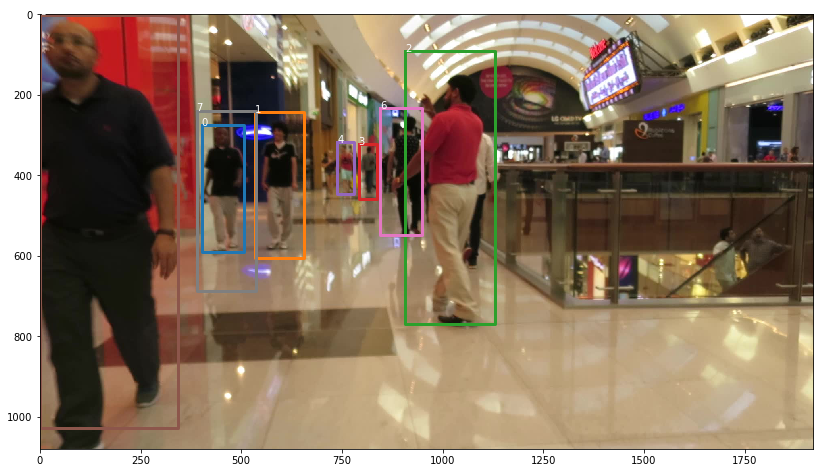

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pak import utils
from pak.datasets.MOT import MOT16
mot16__ = MOT16(root)
X, Y_det, Y_gt = mot16__.get_train("MOT16-11", memmapped=True)

fig = plt.figure(figsize=(16,8))

plt.imshow(X[0])

Y_f1 = utils.extract_eq(mot16.mot16_11_detections, 
                               col=0, value=2)

print(Y_f1.shape)
for idx, (_, x, y, w, h, _) in enumerate(Y_f1):
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    plt.text(x, y, str(idx), color='white')
    plt.plot(bbX, bbY, linewidth=3)

plt.show()

In [3]:
from pak.post_processing import MOT
#ALL_DETECTIONS = mot16.mot16_11_detections[0:len(Nodes)]  # as we do not need all frames..
ALL_DETECTIONS = mot16.mot16_11_true_detections_no_pid[0:len(Nodes)]  # as we do not need all frames..

# Hy = mot16.get_MOT16_11_trajectories()  # true detections
# print(Hy.shape)

Dt = []
for i, (pid, data) in enumerate(zip(Nodes, ALL_DETECTIONS)):
    frame, x, y, w, h, score = data
    Dt.append((frame, pid, x, y, w, h, score))
Dt = np.array(Dt)


print("before", Dt.shape)
Dt = MOT.remove_short_tracks(
    MOT.remove_duplicates(Dt, lambda x: x[5]),
    min_length=0)


print("after", Dt.shape)
Dt = Dt[:,0:6]

print(Dt[0:6].astype('object'))
Dt_f1 = utils.extract_eq(Dt, col=0, value=1)
Dt_f2 = utils.extract_eq(Dt, col=0, value=2)
print("qq", Dt_f2.shape)


Gt = mot16.get_MOT16_11_gt_trajectories()

print(Gt.shape)

threshold=0.5
result, info = MOTA.evaluate_aabb(Gt, Dt, threshold, info=True)


print("MOTA:", result)
print("\tinfo:", info)


before (267, 7)
after (242, 7)
[[1.0 0.0 544.06 249.9 112.14 338.41]
 [1.0 1.0 402.13 275.46 104.56 315.68]
 [1.0 2.0 929.93 127.67 210.12 632.36]
 [1.0 3.0 793.0 329.0 39.0 119.0]
 [2.0 4.0 402.13 275.46 104.56 315.68]
 [2.0 5.0 534.53 243.51 120.26 362.77]]
qq (4, 6)
(3190, 6)
MOTA: 0.0426332288401
	info: {'FN': 2959, 'FP': 11, 'IDSW': 84, 'GT': 3190}
